In [1]:
import os
import glob
import random
import re

import numpy as np
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import piq

In [2]:
def np_free_form_mask(maxVertex, maxLength, maxBrushWidth, maxAngle, h, w):
    """
    Generate a single free-form stroke mask.
    """
    mask = np.zeros((h, w, 1), np.float32)
    numVertex = np.random.randint(maxVertex + 1)  # random number of vertices
    startY = np.random.randint(h)
    startX = np.random.randint(w)
    brushWidth = 0
    for i in range(numVertex):
        # Random angle in radians
        angle = np.random.randint(maxAngle + 1)
        angle = angle / 360.0 * 2 * np.pi
        if i % 2 == 0:
            angle = 2 * np.pi - angle
        length = np.random.randint(maxLength + 1)
        brushWidth = (np.random.randint(10, maxBrushWidth + 1) // 2) * 2  # Ensure even number
        nextY = startY + length * np.cos(angle)
        nextX = startX + length * np.sin(angle)
        nextY = int(np.maximum(np.minimum(nextY, h - 1), 0))
        nextX = int(np.maximum(np.minimum(nextX, w - 1), 0))
        cv2.line(mask, (startY, startX), (nextY, nextX), 1, brushWidth)
        cv2.circle(mask, (startY, startX), brushWidth // 2, 2)
        startY, startX = nextY, nextX
    cv2.circle(mask, (startY, startX), brushWidth // 2, 2)
    return mask

def generate_stroke_mask(im_size,
                                       min_ratio=0.2,
                                       max_ratio=0.3,
                                       max_parts=7,
                                       maxVertex=25,
                                       maxLength=100,
                                       maxBrushWidth=24,
                                       maxAngle=360):
    while True:
        mask = np.zeros((im_size[0], im_size[1], 1), dtype=np.float32)
        parts = random.randint(1, max_parts)
        for _ in range(parts):
            mask += np_free_form_mask(maxVertex, maxLength, maxBrushWidth, maxAngle, im_size[0], im_size[1])
        mask = np.minimum(mask, 1.0)

        coverage = np.mean(mask)  # fraction of pixels that are 1
        if coverage >= min_ratio and coverage <= max_ratio:
            # Convert single-channel to 3-channel if desired
            mask = np.concatenate([mask, mask, mask], axis=2)
            return mask

In [3]:
class DhMuralsDataset(Dataset):
    def __init__(self, image_dir, target_size=256, transform=None):
        """
        Args:
            image_dir (str): Directory containing images.
            target_size (int): Target resolution (square image: target_size x target_size).
            transform (callable, optional): Transformation to apply to the images (default uses center crop & resize).
        """
        self.image_paths = sorted(
            glob.glob(os.path.join(image_dir, '*.jpg')) +
            glob.glob(os.path.join(image_dir, '*.png'))
        )
        self.target_size = target_size
        # If no custom transform is provided, use our default center crop & resize.
        self.transform = transform if transform is not None else self.center_crop_and_resize

    def center_crop_and_resize(self, image):
        """
        Center crops the largest square and resizes the image.
        Args:
            image (PIL.Image): Input image.
        Returns:
            PIL.Image: Cropped and resized image.
        """
        width, height = image.size
        side = min(width, height)
        left = (width - side) // 2
        top = (height - side) // 2
        right = left + side
        bottom = top + side
        image = image.crop((left, top, right, bottom))
        image = image.resize((self.target_size, self.target_size), Image.BILINEAR)
        return image

    def generate_random_mask(self):
        """
        Generates a random mask using free-form strokes.
        Mimics PRN's mask type 1:
            mask = 1 - generate_stroke_mask([target_size, target_size])
            followed by thresholding.
        Returns:
            PIL.Image: Mask image in 8-bit (0 and 255).
        """
        # Generate a stroke mask of size (target_size, target_size)
        mask_array = 1 - generate_stroke_mask((self.target_size, self.target_size))
        # Threshold the mask: values greater than 0 become 1, then scale to 255.
        mask_array = (mask_array > 0).astype(np.uint8) * 255
        # Convert the numpy array to a PIL Image. (The mask is already 3-channel.)
        mask_image = Image.fromarray(mask_array)
        return mask_image

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Loads an image, applies the transformation, and generates a random mask.
        Returns:
            (image_tensor, mask_tensor)
        """
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")  # Convert to RGB for consistent 3-channel input.
        image = self.transform(image)  # center crop & resize the image
        mask = self.generate_random_mask()  # generate corresponding random mask

        # Convert both image and mask to tensors
        image_tensor = ToTensor()(image)
        mask_tensor = ToTensor()(mask)
        return image_tensor, mask_tensor

In [4]:
train_dir = "/home/jincheng/Mural/mural_project/DhMurals1714/DhMurals-inpainting-dataset/train/images"
val_dir   = "/home/jincheng/Mural/mural_project/DhMurals1714/DhMurals-inpainting-dataset/val/images"
test_dir  = "/home/jincheng/Mural/mural_project/DhMurals1714/DhMurals-inpainting-dataset/test/images"

# Create dataset objects for train, validation, and test sets.
train_dataset = DhMuralsDataset(train_dir, target_size=256)
val_dataset   = DhMuralsDataset(val_dir, target_size=256)
test_dataset  = DhMuralsDataset(test_dir, target_size=256)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Batch shapes - images: torch.Size([32, 3, 256, 256]) masks: torch.Size([32, 3, 256, 256])


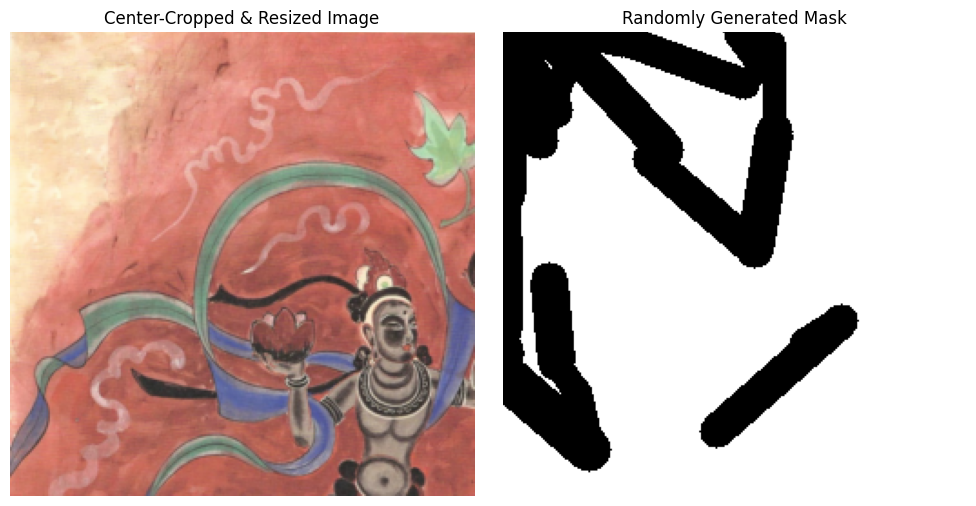

In [5]:
images, masks = next(iter(train_loader))
print("Batch shapes - images:", images.shape, "masks:", masks.shape)

# Convert the first image and mask to numpy arrays for plotting.
# Image shape: (C, H, W) -> (H, W, C)
img_np = images[0].permute(1, 2, 0).numpy()
mask_np = masks[0].permute(1, 2, 0).numpy()  # mask is 3-channel as well

# Plot the image and its corresponding mask side by side.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_np)
ax[0].set_title("Center-Cropped & Resized Image")
ax[0].axis("off")

ax[1].imshow(mask_np, cmap='gray')
ax[1].set_title("Randomly Generated Mask")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [6]:
class PartialConv2d(nn.Module):
    """
    A partial convolution layer that processes only the unmasked (valid) pixels.
    During the forward pass, the input tensor is first element-wise multiplied
    by the mask, and then a standard convolution is applied. The output is normalized 
    by the sum of the mask in the convolution window to account for missing pixels.
    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=True):
        super(PartialConv2d, self).__init__()
        self.input_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                    stride=stride, padding=padding, dilation=dilation, bias=bias)
        self.kernel_size = self.input_conv.kernel_size
        self.stride = self.input_conv.stride
        self.padding = self.input_conv.padding
        # Calculate the size of the sliding window (used for normalization)
        self.slide_window_size = self.kernel_size[0] * self.kernel_size[1]

    def forward(self, input, mask):
        # Multiply input by mask: undamaged regions remain; damaged become 0.
        input_masked = input * mask

        # Apply convolution on the masked input.
        conv_output = self.input_conv(input_masked)

        # Compute the sum of mask values in each convolution window.
        # We use a kernel of ones with the same size as the convolution kernel.
        with torch.no_grad():
            ones_kernel = torch.ones((1, 1, self.kernel_size[0], self.kernel_size[1]), device=input.device)
            # Note: we assume mask has the same spatial dimensions as input and
            # that the mask is broadcastable over channels.
            mask_sum = F.conv2d(mask, ones_kernel, bias=None, stride=self.stride, padding=self.padding)

        # Avoid division by zero.
        eps = 1e-8
        mask_sum_safe = mask_sum + eps

        # Normalize the convolution output: divide by the number of valid (non-masked) pixels.
        output = conv_output / mask_sum_safe

        # Where there is no valid pixel in the receptive field, set the output to zero.
        output = output * (mask_sum > 0).float()

        # Update the mask: if any pixel in the window was valid, the new mask is 1.
        new_mask = F.conv2d(mask, ones_kernel, bias=None, stride=self.stride, padding=self.padding)
        new_mask = torch.where(new_mask > 0, torch.ones_like(new_mask), torch.zeros_like(new_mask))

        return output, new_mask

In [7]:
class PartialConvInpaintingNet(nn.Module):
    """
    A simple partial convolution inpainting network with an encoder-decoder structure.
    The encoder uses PartialConv2d layers while the decoder uses standard transposed
    convolutions. This network takes an image and a corresponding mask (where damaged 
    regions are 0 and undamaged ones are 1) as input and returns an inpainted output.
    """
    def __init__(self):
        super(PartialConvInpaintingNet, self).__init__()
        # Encoder: partial convolution layers
        self.pconv1 = PartialConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.pconv2 = PartialConv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.pconv3 = PartialConv2d(128, 256, kernel_size=3, stride=2, padding=1)

        # Decoder: transposed convolutions for upsampling
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2,
                                          padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2,
                                          padding=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 3, kernel_size=7, stride=2,
                                          padding=3, output_padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, mask):
        # Encoder: each partial conv layer produces an updated feature map and mask.
        x1, mask1 = self.pconv1(x, mask)
        x1 = self.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = self.relu(x2)
        x3, mask3 = self.pconv3(x2, mask2)
        x3 = self.relu(x3)

        # Decoder: upsample progressively using transposed convolutions.
        d1 = self.relu(self.deconv1(x3))
        d2 = self.relu(self.deconv2(d1))
        # Use sigmoid at the end to normalize the output to [0, 1]
        d3 = torch.sigmoid(self.deconv3(d2))
        return d3

In [8]:
def train_inpainting_model(
        model,
        train_loader,
        val_loader,
        device,
        num_epochs=20,
        lr=2e-4
):
    """
    Trains the given inpainting model using:
      1) L1 loss on the composited output (comp_B) vs. ground truth
      2) L1 loss in the hole region (fake_B vs. real_B, only where mask=0)
    Also computes SSIM, PSNR, LPIPS on the validation set, and plots train/val losses.

    Args:
        model (nn.Module): The inpainting network.
        train_loader (DataLoader): Yields (images, masks) for training.
        val_loader (DataLoader): Yields (images, masks) for validation.
        device (torch.device): CPU or GPU.
        num_epochs (int): Number of epochs.
        lr (float): Learning rate.

    Returns:
        dict: Contains training history (losses, SSIM, PSNR, LPIPS).
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()

    # Containers for logging/plotting
    train_losses = []
    val_losses = []
    val_ssims = []
    val_psnrs = []
    val_lpipses = []

    # LPIPS metric object
    lpips_fn = piq.LPIPS()

    for epoch in range(num_epochs):
        # -------------------
        #     Training
        # -------------------
        model.train()
        running_train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
            images = images.to(device)             # Ground truth
            # If your masks are 3-channel, reduce to 1 channel:
            masks = masks[:, :1, :, :].to(device)  # shape [N,1,H,W]

            # Forward pass: model should output the inpainted image (fake_B)
            fake_B = model(images, masks)

            # Composite the raw output into unmasked areas
            comp_B = fake_B * (1 - masks) + images * masks

            # 1) Composite loss (entire image)
            comp_loss = criterion(comp_B, images)

            # 2) Hole loss (only in the masked area)
            #    Note: (1 - masks) is 1 where the hole is, 0 in known regions
            hole_loss = criterion(fake_B * (1 - masks), images * (1 - masks))

            # Combine them (weights can be adjusted if desired)
            total_loss = comp_loss + hole_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_train_loss += total_loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # -------------------
        #   Validation
        # -------------------
        model.eval()
        running_val_loss = 0.0
        ssim_val = 0.0
        psnr_val = 0.0
        lpips_val = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
                images = images.to(device)
                masks = masks[:, :1, :, :].to(device)

                fake_B = model(images, masks)
                comp_B = fake_B * (1 - masks) + images * masks

                # Same total loss in validation
                comp_loss = criterion(comp_B, images)
                hole_loss = criterion(fake_B * (1 - masks), images * (1 - masks))
                val_loss = comp_loss + hole_loss

                running_val_loss += val_loss.item()

                # Evaluate metrics on the composited output vs. ground truth
                ssim_val += piq.ssim(comp_B, images, data_range=1.0).item()
                psnr_val += piq.psnr(comp_B, images, data_range=1.0).item()
                lpips_val += lpips_fn(comp_B, images).item()

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_ssim = ssim_val / len(val_loader)
        epoch_val_psnr = psnr_val / len(val_loader)
        epoch_val_lpips = lpips_val / len(val_loader)

        val_losses.append(epoch_val_loss)
        val_ssims.append(epoch_val_ssim)
        val_psnrs.append(epoch_val_psnr)
        val_lpipses.append(epoch_val_lpips)

        # Print summary
        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"SSIM: {epoch_val_ssim:.4f} | "
              f"PSNR: {epoch_val_psnr:.4f} | "
              f"LPIPS: {epoch_val_lpips:.4f}")

    # -------------------
    #  Plotting Losses
    # -------------------
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Train/Validation Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_ssim": val_ssims,
        "val_psnr": val_psnrs,
        "val_lpips": val_lpipses
    }

/home/jincheng/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jincheng/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1/20] Train Loss: 0.1084 | Val Loss: 0.1083 | SSIM: 0.7834 | PSNR: 18.0767 | LPIPS: 0.2680


[Epoch 2/20] Train Loss: 0.1013 | Val Loss: 0.0994 | SSIM: 0.8003 | PSNR: 18.7147 | LPIPS: 0.2579


[Epoch 3/20] Train Loss: 0.0925 | Val Loss: 0.0908 | SSIM: 0.7991 | PSNR: 19.2866 | LPIPS: 0.2628


[Epoch 4/20] Train Loss: 0.0808 | Val Loss: 0.0741 | SSIM: 0.8141 | PSNR: 20.6595 | LPIPS: 0.2472


[Epoch 5/20] Train Loss: 0.0737 | Val Loss: 0.0728 | SSIM: 0.8086 | PSNR: 20.9075 | LPIPS: 0.2473


[Epoch 6/20] Train Loss: 0.0706 | Val Loss: 0.0700 | SSIM: 0.8133 | PSNR: 21.1220 | LPIPS: 0.2503


[Epoch 7/20] Train Loss: 0.0687 | Val Loss: 0.0652 | SSIM: 0.8224 | PSNR: 21.6451 | LPIPS: 0.2478


[Epoch 8/20] Train Loss: 0.0670 | Val Loss: 0.0671 | SSIM: 0.8199 | PSNR: 21.3930 | LPIPS: 0.2501


[Epoch 9/20] Train Loss: 0.0653 | Val Loss: 0.0617 | SSIM: 0.8305 | PSNR: 21.9513 | LPIPS: 0.2392


[Epoch 10/20] Train Loss: 0.0652 | Val Loss: 0.0619 | SSIM: 0.8299 | PSNR: 21.9067 | LPIPS: 0.2348


[Epoch 11/20] Train Loss: 0.0652 | Val Loss: 0.0629 | SSIM: 0.8262 | PSNR: 21.9102 | LPIPS: 0.2437


[Epoch 12/20] Train Loss: 0.0644 | Val Loss: 0.0639 | SSIM: 0.8232 | PSNR: 21.8345 | LPIPS: 0.2461


[Epoch 13/20] Train Loss: 0.0642 | Val Loss: 0.0662 | SSIM: 0.8214 | PSNR: 21.6341 | LPIPS: 0.2510


[Epoch 14/20] Train Loss: 0.0640 | Val Loss: 0.0627 | SSIM: 0.8250 | PSNR: 21.9762 | LPIPS: 0.2487


[Epoch 15/20] Train Loss: 0.0636 | Val Loss: 0.0651 | SSIM: 0.8236 | PSNR: 21.6789 | LPIPS: 0.2449


[Epoch 16/20] Train Loss: 0.0635 | Val Loss: 0.0615 | SSIM: 0.8273 | PSNR: 22.0552 | LPIPS: 0.2449


[Epoch 17/20] Train Loss: 0.0631 | Val Loss: 0.0603 | SSIM: 0.8300 | PSNR: 22.1719 | LPIPS: 0.2408


[Epoch 18/20] Train Loss: 0.0635 | Val Loss: 0.0622 | SSIM: 0.8277 | PSNR: 21.9498 | LPIPS: 0.2429


[Epoch 19/20] Train Loss: 0.0632 | Val Loss: 0.0629 | SSIM: 0.8299 | PSNR: 21.9441 | LPIPS: 0.2424


[Epoch 20/20] Train Loss: 0.0632 | Val Loss: 0.0598 | SSIM: 0.8324 | PSNR: 22.1938 | LPIPS: 0.2407


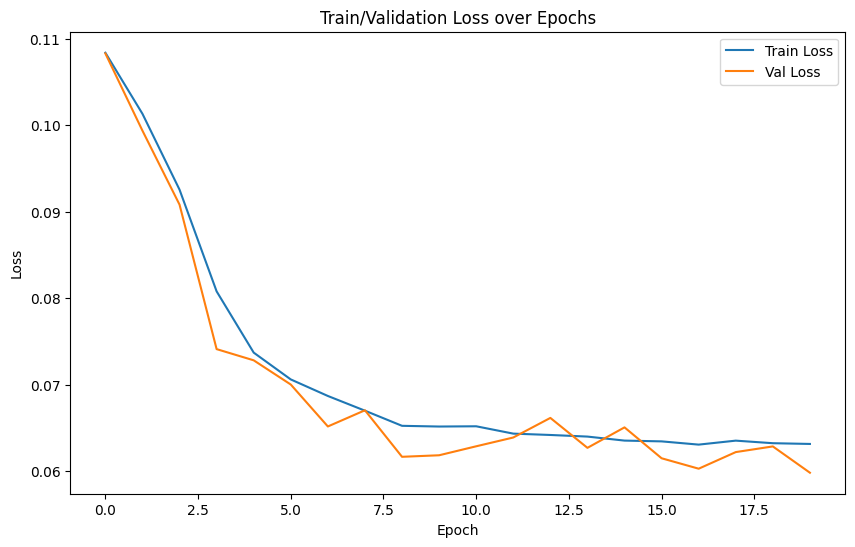

In [9]:
model = PartialConvInpaintingNet()  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_history = train_inpainting_model(
    model, 
    train_loader, 
    val_loader, 
    device, 
    num_epochs=20, 
    lr=2e-4
)

In [10]:
def test_inpainting_model(model, test_loader, device):
    """
    Tests the inpainting model on the test_loader. 
    Plots one sample (original image vs. inpainted result) and 
    prints average SSIM, PSNR, and LPIPS across the test set.
    
    Args:
        model (nn.Module): Trained inpainting model (in eval mode).
        test_loader (DataLoader): DataLoader for the test set, yielding (images, masks).
        device (torch.device): 'cuda' or 'cpu'.
    
    Returns:
        dict: A dictionary containing average SSIM, PSNR, LPIPS.
    """
    model.to(device)
    model.eval()

    # We’ll accumulate the metrics here
    ssim_vals = []
    psnr_vals = []
    lpips_vals = []

    # LPIPS object from piq (defaults to VGG16)
    lpips_fn = piq.LPIPS()

    # We'll store one sample for plotting
    example_masked = None
    example_inpainted = None

    with torch.no_grad():
        # Iterate over the test dataset
        for images, masks in tqdm(test_loader, desc="Testing", leave=False):
            images = images.to(device)  # shape: [N, 3, H, W] (for RGB)
            masks = masks[:, :1, :, :].to(device)   # shape: [N, 1, H, W] or [N, 3, H, W] depending on your dataset

            # Forward pass through your model
            # If your model returns more than one output, adjust accordingly
            inpainted = model(images, masks)

            composite = inpainted * (1 - masks) + images * masks

            # Compute metrics:
            # We assume images and inpainted are in [0,1] range. If not, set data_range=255 if [0,255].
            ssim_batch = piq.ssim(composite, images, data_range=1.0)
            psnr_batch = piq.psnr(composite, images, data_range=1.0)
            lpips_batch = lpips_fn(composite, images)

            ssim_vals.append(ssim_batch.cpu().item())
            psnr_vals.append(psnr_batch.cpu().item())
            lpips_vals.append(lpips_batch.cpu().item())

            # Store one sample (the first image in this batch) for plotting
            if example_masked is None:
                # 'images[0]' is the original unmasked image
                # 'masks[0]' is the corresponding mask
                # The "original combined with mask" means the masked image:
                # masked_image = original_image * mask
                example_masked = (images[0] * masks[0]).detach().cpu()
                example_inpainted = composite[0].detach().cpu()

    # Compute average metrics
    avg_ssim  = np.mean(ssim_vals)
    avg_psnr  = np.mean(psnr_vals)
    avg_lpips = np.mean(lpips_vals)

    # Print final metrics
    print("=== Test Results ===")
    print(f"SSIM:  {avg_ssim:.4f}")
    print(f"PSNR:  {avg_psnr:.4f}")
    print(f"LPIPS: {avg_lpips:.4f}")

    # Plot a sample: "original combined with mask" (masked image) and the "inpainted result"
    if example_masked is not None and example_inpainted is not None:
        # Convert to numpy for matplotlib
        # shape: [C, H, W] -> [H, W, C]
        masked_np = example_masked.permute(1, 2, 0).numpy()
        inpainted_np = example_inpainted.permute(1, 2, 0).numpy()

        # Plot side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(np.clip(masked_np, 0, 1))
        axes[0].set_title("Original + Mask (Masked Image)")
        axes[0].axis("off")

        axes[1].imshow(np.clip(inpainted_np, 0, 1))
        axes[1].set_title("Inpainted Result")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

    # Return metrics if you want to store them
    return {
        "ssim": avg_ssim,
        "psnr": avg_psnr,
        "lpips": avg_lpips
    }

=== Test Results ===
SSIM:  0.8188
PSNR:  21.8780
LPIPS: 0.2446


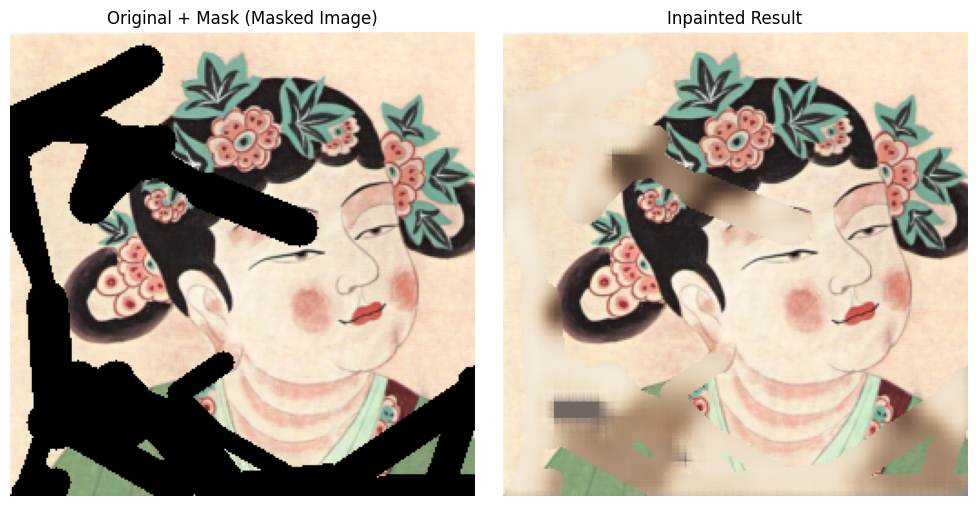

In [11]:
test_metrics = test_inpainting_model(model, test_loader, device)